This notebook contains the data processing and analyses for Flaherty, Sato & Kirby (2020). 

The following steps for pre-processing the data are not included in this notebook, as these involve the manipulation of confidential (e.g. video) data:

1. Transformation of kinect data by a scaling factor to enable comparison of body tracking data obtained from people with differing body sizes. All data was scaled using a scaling factor obtained from each participant's forearm length. 
2. Time-aligning of kinect data and video data for glossing
 


In [4]:
setwd("/Users/Asha/Flaherty_Sato_Kirby_2020")
list.files()

# two data sources: scaled kinect data for the whole session and glossed utterances with start and end frames.

# body_data <- read.csv("whole_session_data_scaled.csv")
# gloss <- read.csv("utterance_glosses.csv")


[1] "body_wrist_distances.csv"          "bounding_box_data.csv"            
[3] "mp_distance_plot.jpeg"             "plots"                            
[5] "utterance_glosses.csv"             "whole_session_data_scaled.csv"    
[7] "whole_session_data_scaled.csv.zip" "whole_session_data_segmented.csv" 
[9] "year_of_entry.csv"

In [5]:
# looking at the glossed data

gloss <- gloss[order(gloss$Utt.number),] #re-order so utterances are in order. 
head(gloss,1)

# a typing error means the utterance numbers are not sequential:
# unique(gloss$Utt.number) 

# sequential utterance numbers are assigned in a new column (correspondence to number in original coding is preserved)
gloss$utterance_number <- factor(gloss$Utt.number)
levels(gloss$utterance_number) <- seq(1:length(unique(gloss$Utt.number)))


head(gloss$utterance_number)
tail(gloss$utterance_number)


,Signer,Subject.Info..cohort,DomHand,Stimuli..ItemNum,Stimuli..Action,Stimuli..Actor,Stimuli..Patient,Stimuli..ObjectAnimacy,Utt.number,Utterance..Utterance.Frame1,Utterance..Utterance.last.frame,Gloss,Verb.number.from.previous.coding,Verb,Target.,Verb.Category,Verb.Category2,First.Frame,Last.Frame
363,145,2,right,A01,hop,woman,man,animate,1,611,842,M stand-inv-VCL-R W stand-inv-VCL-L hop-inv-VCL-on-RH M approach-sym-GCL-2H approach-VCL-inv-to-GCL,1,hop-inv-VCL-on-RH,yes,CL,CL,729,753


[1] 1 1 1 2 3 3
571 Levels: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 ... 571

[1] 567 567 568 569 570 571
571 Levels: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 ... 571

In [6]:
# looking at the body data 

head(body_data)

X,TimeStamp,skeletonID,HIP_CENTER_X,HIP_CENTER_Y,HIP_CENTER_Z,HIP_CENTER_TRACKSTATE,SPINE_X,SPINE_Y,SPINE_Z,⋯,HANDTIP_RIGHT_X,HANDTIP_RIGHT_Y,HANDTIP_RIGHT_Z,HANDTIP_RIGHT_TRACKSTATE,THUMB_RIGHT_X,THUMB_RIGHT_Y,THUMB_RIGHT_Z,THUMB_RIGHT_TRACKSTATE,ppt,frame
1,0,p145,-1.077539,43.32181,10.54582,2,-0.5303964,21.48334,4.773968,⋯,-9.787773,50.14894,44.38322,2,9.626906,45.15596,33.81789,2,145,1
2,330000,p145,-1.075829,43.31837,10.54087,2,-0.5293005,21.48007,4.771533,⋯,-9.733010,50.14567,44.37616,2,9.607392,45.15294,33.81083,2,145,2
3,660000,p145,-1.076676,43.31702,10.54198,2,-0.5297687,21.47872,4.772301,⋯,-9.676893,50.14432,44.37551,2,9.606544,45.15159,33.81018,2,145,3
4,990000,p145,-1.080757,43.31405,10.54309,2,-0.5331418,21.47572,4.773069,⋯,-9.631944,50.14135,44.37486,2,9.571699,45.20972,33.91006,2,145,4
5,1320000,p145,-1.086078,43.31236,10.54309,2,-0.5380574,21.47387,4.773069,⋯,-9.645170,50.30567,44.62518,2,9.535456,45.26896,34.01059,2,145,5
6,1650000,p145,-1.087857,43.31108,10.54309,2,-0.5395034,21.47244,4.773069,⋯,-9.444553,50.77382,44.96740,2,9.524084,45.34954,34.14020,2,145,6


### Combining body data and glossed data


In [7]:
# first we get a dataframe with utterance start and end points for each utterance
utterances <- as.data.frame(unique(cbind(id = gloss$Signer,  utterance_number = gloss$utterance_number, start_frame = gloss$Utterance..Utterance.Frame1, end_frame = gloss$Utterance..Utterance.last.frame)))

head(utterances,3)
tail(utterances,3)

id,utterance_number,start_frame,end_frame
145,1,611,842
145,2,1231,1458
145,3,1793,2107


,id,utterance_number,start_frame,end_frame
569,27,569,16331,16508
570,27,570,16723,16908
571,27,571,17093,17352


In [8]:
#give body dataframe a column with id that matches the one in utterances dataframe for merging
body_data$id <- as.numeric(substring(body_data$skeletonID,2))
head(body_data)

X,TimeStamp,skeletonID,HIP_CENTER_X,HIP_CENTER_Y,HIP_CENTER_Z,HIP_CENTER_TRACKSTATE,SPINE_X,SPINE_Y,SPINE_Z,⋯,HANDTIP_RIGHT_Y,HANDTIP_RIGHT_Z,HANDTIP_RIGHT_TRACKSTATE,THUMB_RIGHT_X,THUMB_RIGHT_Y,THUMB_RIGHT_Z,THUMB_RIGHT_TRACKSTATE,ppt,frame,id
1,0,p145,-1.077539,43.32181,10.54582,2,-0.5303964,21.48334,4.773968,⋯,50.14894,44.38322,2,9.626906,45.15596,33.81789,2,145,1,145
2,330000,p145,-1.075829,43.31837,10.54087,2,-0.5293005,21.48007,4.771533,⋯,50.14567,44.37616,2,9.607392,45.15294,33.81083,2,145,2,145
3,660000,p145,-1.076676,43.31702,10.54198,2,-0.5297687,21.47872,4.772301,⋯,50.14432,44.37551,2,9.606544,45.15159,33.81018,2,145,3,145
4,990000,p145,-1.080757,43.31405,10.54309,2,-0.5331418,21.47572,4.773069,⋯,50.14135,44.37486,2,9.571699,45.20972,33.91006,2,145,4,145
5,1320000,p145,-1.086078,43.31236,10.54309,2,-0.5380574,21.47387,4.773069,⋯,50.30567,44.62518,2,9.535456,45.26896,34.01059,2,145,5,145
6,1650000,p145,-1.087857,43.31108,10.54309,2,-0.5395034,21.47244,4.773069,⋯,50.77382,44.96740,2,9.524084,45.34954,34.14020,2,145,6,145


In [9]:
# merge the two dataframes, using start and end frames from utterances to label frames with their utterance number or NA

m <- merge(body_data, do.call(rbind, apply(utterances, 1
  , function(x) cbind(id=x[1], utterance_number=x[2], frame=x[3]:x[4])))
 , all.x=TRUE)
    
m <- m[order(m$id),]
head(m)


,frame,id,X,TimeStamp,skeletonID,HIP_CENTER_X,HIP_CENTER_Y,HIP_CENTER_Z,HIP_CENTER_TRACKSTATE,SPINE_X,⋯,HANDTIP_RIGHT_X,HANDTIP_RIGHT_Y,HANDTIP_RIGHT_Z,HANDTIP_RIGHT_TRACKSTATE,THUMB_RIGHT_X,THUMB_RIGHT_Y,THUMB_RIGHT_Z,THUMB_RIGHT_TRACKSTATE,ppt,utterance_number
1,1,27,95757,0,p27,1.0822322,47.14464,12.35252,2,0.1706741,⋯,-7.519928,14.15412,65.84434,2,2.582145,-6.50609,55.91675,2,27,NA
18,2,27,95758,330000,p27,1.0267540,47.14464,12.31889,2,0.1706741,⋯,-7.220726,14.15412,65.55738,2,2.582145,-6.50609,55.84663,2,27,NA
35,3,27,95759,660000,p27,0.9836366,47.14464,12.34791,2,0.1830348,⋯,-6.743763,15.32503,65.25899,2,2.594505,-6.50609,55.77650,2,27,NA
52,4,27,95760,990000,p27,0.9959974,47.14464,12.41057,2,0.1953956,⋯,-6.566003,16.49593,65.24757,2,2.606866,-6.50609,55.77650,2,27,NA
69,5,27,95761,1320000,p27,1.0083581,47.14464,12.49694,2,0.2077563,⋯,-6.041157,18.54559,64.75792,2,3.358473,-6.50609,55.77650,2,27,NA
86,6,27,95762,1650000,p27,1.0083581,47.14464,12.52066,2,0.2077563,⋯,-5.694071,19.42436,64.27970,2,4.097719,-6.50609,55.77650,2,27,NA


In [10]:
# add column specifying frame type (utterance or not)
m$is_utterance <- ifelse(is.na(m$utterance_number) == TRUE, 0,1)

# assign 'segment numbers'
# for utterances this is the utterance number
# for non-utterance segments this is taken from the adjacent utterance number.
require(zoo)
m$segment_number <- na.locf(m$utterance_number, na.rm = FALSE, by = list(m$id))  
m$segment_number <- na.locf(m$segment_number, na.rm = FALSE, by = list(m$id), fromLast = TRUE)

head(m,3)
tail(m,3)


Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



,frame,id,X,TimeStamp,skeletonID,HIP_CENTER_X,HIP_CENTER_Y,HIP_CENTER_Z,HIP_CENTER_TRACKSTATE,SPINE_X,⋯,HANDTIP_RIGHT_Z,HANDTIP_RIGHT_TRACKSTATE,THUMB_RIGHT_X,THUMB_RIGHT_Y,THUMB_RIGHT_Z,THUMB_RIGHT_TRACKSTATE,ppt,utterance_number,is_utterance,segment_number
1,1,27,95757,0,p27,1.0822322,47.14464,12.35252,2,0.1706741,⋯,65.84434,2,2.582145,-6.50609,55.91675,2,27,NA,0,538
18,2,27,95758,330000,p27,1.0267540,47.14464,12.31889,2,0.1706741,⋯,65.55738,2,2.582145,-6.50609,55.84663,2,27,NA,0,538
35,3,27,95759,660000,p27,0.9836366,47.14464,12.34791,2,0.1830348,⋯,65.25899,2,2.594505,-6.50609,55.77650,2,27,NA,0,538


,frame,id,X,TimeStamp,skeletonID,HIP_CENTER_X,HIP_CENTER_Y,HIP_CENTER_Z,HIP_CENTER_TRACKSTATE,SPINE_X,⋯,HANDTIP_RIGHT_Z,HANDTIP_RIGHT_TRACKSTATE,THUMB_RIGHT_X,THUMB_RIGHT_Y,THUMB_RIGHT_Z,THUMB_RIGHT_TRACKSTATE,ppt,utterance_number,is_utterance,segment_number
226067,14023,736,237510,4627260000,p736,-0.4105964,47.753,12.071126,2,-0.9250250,⋯,51.02852,1.6,5.587944,22.98619,50.14849,1.6,736,NA,0,67
226074,14024,736,237511,4627590000,p736,-0.8650965,47.753,12.071126,2,-1.3279419,⋯,51.02852,1.8,5.133444,22.98619,50.12907,1.8,736,NA,0,67
226081,14025,736,237512,4627920000,p736,-1.3195967,47.753,9.894487,2,-0.8947802,⋯,49.04226,2.0,5.290333,23.26885,48.71683,2.0,736,NA,0,67


In [11]:
# utterance 65 is excluded (71 in original coding) due to failure of the device
# keep NA
m <- subset(m, utterance_number != 65|is.na(utterance_number))


In [41]:
write.csv(m,"whole_session_data_segmented.csv", row.names = FALSE)

# BOUNDING BOX

In [1]:
setwd("/Users/Asha/Flaherty_Sato_Kirby_2020")
list.files()

[1] "body_wrist_distances.csv"          "bounding_box_data.csv"            
 [3] "mp_distance_plot.jpeg"             "mp_distances.csv"                 
 [5] "plots"                             "utterance_glosses.csv"            
 [7] "whole_session_data_scaled.csv"     "whole_session_data_scaled.csv.zip"
 [9] "whole_session_data_segmented.csv"  "year_of_entry.csv"

In [ ]:
dat <- read.csv("whole_session_data_segmented.csv")

In [3]:
head(dat)

frame,id,X,TimeStamp,skeletonID,HIP_CENTER_X,HIP_CENTER_Y,HIP_CENTER_Z,HIP_CENTER_TRACKSTATE,SPINE_X,⋯,HANDTIP_RIGHT_Z,HANDTIP_RIGHT_TRACKSTATE,THUMB_RIGHT_X,THUMB_RIGHT_Y,THUMB_RIGHT_Z,THUMB_RIGHT_TRACKSTATE,ppt,utterance_number,is_utterance,segment_number
1,27,95757,0,p27,1.0822322,47.14464,12.35252,2,0.1706741,⋯,65.84434,2,2.582145,-6.50609,55.91675,2,27,NA,0,538
2,27,95758,330000,p27,1.0267540,47.14464,12.31889,2,0.1706741,⋯,65.55738,2,2.582145,-6.50609,55.84663,2,27,NA,0,538
3,27,95759,660000,p27,0.9836366,47.14464,12.34791,2,0.1830348,⋯,65.25899,2,2.594505,-6.50609,55.77650,2,27,NA,0,538
4,27,95760,990000,p27,0.9959974,47.14464,12.41057,2,0.1953956,⋯,65.24757,2,2.606866,-6.50609,55.77650,2,27,NA,0,538
5,27,95761,1320000,p27,1.0083581,47.14464,12.49694,2,0.2077563,⋯,64.75792,2,3.358473,-6.50609,55.77650,2,27,NA,0,538
6,27,95762,1650000,p27,1.0083581,47.14464,12.52066,2,0.2077563,⋯,64.27970,2,4.097719,-6.50609,55.77650,2,27,NA,0,538


In [4]:
cat("number of frames in dataset:")
nrow(dat)

cat("number of frames coded as utterances:")
nrow(subset(dat, is.na(dat$utterance_number)))

cat("number of frames not coded as utterances:")
nrow(subset(dat, !is.na(dat$utterance_number)))


number of frames in dataset:

[1] 238253

number of frames coded as utterances:

[1] 140955

number of frames not coded as utterances:

[1] 97298

## getting the bounding box

In [5]:
#empty vectors to store length, height, width, volume, box centre X Y and Z, frame type
id_vec <- c()
utt_vec <- c()

length_vec <- c()
height_vec <- c()
width_vec <- c()

volume_vec <- c()

centX_vec <- c()
centY_vec <- c()
centZ_vec <- c()

frame_type_vec <- c()


#loop over segment number calculating the above and adding to them to the vector 

for (s in seq(1:length(unique(dat$segment_number)))) {
    
    #grab utterance data
    frame_type <- "UTT"
    df <- subset(dat, segment_number == s & is_utterance == 1)
    iD <- as.character(df$skeletonID[2])
    
    #get mins and max wrist positions
    minX <- min(c(df$WRIST_LEFT_X, df$WRIST_RIGHT_X))
    minY <- min(c(df$WRIST_LEFT_Y, df$WRIST_RIGHT_Y))
    minZ <- min(c(df$WRIST_LEFT_Z, df$WRIST_RIGHT_Z))
        
    maxX <- max(c(df$WRIST_LEFT_X, df$WRIST_RIGHT_X))
    maxY <- max(c(df$WRIST_LEFT_Y, df$WRIST_RIGHT_Y))
    maxZ <- max(c(df$WRIST_LEFT_Z, df$WRIST_RIGHT_Z))

    #get box dimensions
    length <- maxX - minX
    height <- maxY - minY
    width <- maxZ - minZ
    
    #get centre of the box
    cX <- (minX+maxX)/2
    cY <- (minY+maxY)/2
    cZ <- (minZ+maxZ)/2
    
    #store in vectors
    id_vec <- c(id_vec, iD)
    utt_vec <- c(utt_vec, s)
    length_vec <- c(length_vec, length)
    height_vec <- c(height_vec, height)
    width_vec <- c(width_vec, width)
    centX_vec <- c(centX_vec, cX)
    centY_vec <- c(centY_vec, cY)
    centZ_vec <- c(centZ_vec, cZ)
    frame_type_vec <-c(frame_type_vec, frame_type)
    
       #grab this signer's non-utterance data
    
    frame_type <- "NON_UTT"
    df <- subset(dat, segment_number == s & is_utterance == 0)
    
    #get mins and max wrist positions
    minX <- min(c(df$WRIST_LEFT_X, df$WRIST_RIGHT_X))
    minY <- min(c(df$WRIST_LEFT_Y, df$WRIST_RIGHT_Y))
    minZ <- min(c(df$WRIST_LEFT_Z, df$WRIST_RIGHT_Z))
        
    maxX <- max(c(df$WRIST_LEFT_X, df$WRIST_RIGHT_X))
    maxY <- max(c(df$WRIST_LEFT_Y, df$WRIST_RIGHT_Y))
    maxZ <- max(c(df$WRIST_LEFT_Z, df$WRIST_RIGHT_Z))

    #get box dimensions
    length <- maxX - minX
    height <- maxY - minY
    width <- maxZ - minZ
    
    #get centre of the box
    cX <- (minX+maxX)/2
    cY <- (minY+maxY)/2
    cZ <- (minZ+maxZ)/2
    
    #store in vectors
    id_vec <- c(id_vec, iD)
    utt_vec <- c(utt_vec, s)
    length_vec <- c(length_vec, length)
    height_vec <- c(height_vec, height)
    width_vec <- c(width_vec, width)
    centX_vec <- c(centX_vec, cX)
    centY_vec <- c(centY_vec, cY)
    centZ_vec <- c(centZ_vec, cZ)
    frame_type_vec <-c(frame_type_vec, frame_type)

}


Warning message in min(c(df$WRIST_LEFT_X, df$WRIST_RIGHT_X)):
“no non-missing arguments to min; returning Inf”Warning message in min(c(df$WRIST_LEFT_Y, df$WRIST_RIGHT_Y)):
“no non-missing arguments to min; returning Inf”Warning message in min(c(df$WRIST_LEFT_Z, df$WRIST_RIGHT_Z)):
“no non-missing arguments to min; returning Inf”Warning message in max(c(df$WRIST_LEFT_X, df$WRIST_RIGHT_X)):
“no non-missing arguments to max; returning -Inf”Warning message in max(c(df$WRIST_LEFT_Y, df$WRIST_RIGHT_Y)):
“no non-missing arguments to max; returning -Inf”Warning message in max(c(df$WRIST_LEFT_Z, df$WRIST_RIGHT_Z)):
“no non-missing arguments to max; returning -Inf”Warning message in min(c(df$WRIST_LEFT_X, df$WRIST_RIGHT_X)):
“no non-missing arguments to min; returning Inf”Warning message in min(c(df$WRIST_LEFT_Y, df$WRIST_RIGHT_Y)):
“no non-missing arguments to min; returning Inf”Warning message in min(c(df$WRIST_LEFT_Z, df$WRIST_RIGHT_Z)):
“no non-missing arguments to min; returning Inf”Warning

In [6]:
bbox <- data.frame(Signer = substr(as.character(id_vec),2,nchar(as.character(id_vec))),
                   # Signer = id_vec,
                   segment = utt_vec,
                  length = length_vec,
                  height = height_vec,
                  width = width_vec,
                  box_centre_X = centX_vec,
                  box_centre_Y = centY_vec,
                  box_centre_Z = centZ_vec,
                  frame_type = frame_type_vec)

bbox$volume_cm3 <- bbox$length*bbox$width*bbox$height
bbox$volume_m3 <- bbox$volume_cm3*.000001


In [7]:
nrow(bbox)
head(bbox)
tail(bbox)

[1] 1142

Signer,segment,length,height,width,box_centre_X,box_centre_Y,box_centre_Z,frame_type,volume_cm3,volume_m3
145,1,56.74205,51.59898,19.44239,5.5419377,17.03394,30.81208,UTT,56924.04,0.05692404
145,1,44.12153,39.81542,23.43968,4.1543719,27.05273,34.02032,NON_UTT,41176.88,0.04117688
145,2,60.66295,48.58833,19.71437,4.0268206,18.59255,28.16856,UTT,58108.32,0.05810832
145,2,45.10204,40.06893,17.69594,0.6433285,28.82841,26.12030,NON_UTT,31979.93,0.03197993
145,3,66.59803,50.49503,36.16762,0.2503686,21.57744,27.27065,UTT,121626.99,0.12162699
145,3,37.41450,38.13664,12.04355,2.5895968,25.22810,26.45386,NON_UTT,17184.49,0.01718449


,Signer,segment,length,height,width,box_centre_X,box_centre_Y,box_centre_Z,frame_type,volume_cm3,volume_m3
1137,27,569,29.84112,33.64864,28.61104,3.768529,25.005613,35.33663,UTT,28728.73,0.02872873
1138,27,569,26.36786,46.03490,15.56262,5.011532,20.402854,34.97346,NON_UTT,18890.57,0.01889057
1139,27,570,49.06730,35.32256,36.14191,4.685199,16.689112,37.51391,UTT,62640.52,0.06264052
1140,27,570,31.38950,51.44635,28.33847,5.006343,19.111937,28.92029,NON_UTT,45763.08,0.04576308
1141,27,571,25.27711,56.98840,28.97277,5.182069,14.031928,32.79516,UTT,41735.34,0.04173534
1142,27,571,41.42296,77.01119,30.93705,1.086545,6.079196,36.67653,NON_UTT,98690.16,0.09869016


In [8]:
#merge with Year of Entry
YoE <- read.csv("year_of_entry.csv")
bbox <- merge(bbox, YoE)

head(bbox)

Signer,segment,length,height,width,box_centre_X,box_centre_Y,box_centre_Z,frame_type,volume_cm3,volume_m3,cohort,YoE
145,1,44.12153,39.81542,23.43968,4.1543719,27.05273,34.02032,NON_UTT,41176.88,0.04117688,2,1990
145,2,60.66295,48.58833,19.71437,4.0268206,18.59255,28.16856,UTT,58108.32,0.05810832,2,1990
145,1,56.74205,51.59898,19.44239,5.5419377,17.03394,30.81208,UTT,56924.04,0.05692404,2,1990
145,3,37.41450,38.13664,12.04355,2.5895968,25.22810,26.45386,NON_UTT,17184.49,0.01718449,2,1990
145,4,71.80234,52.40963,47.28846,4.0785286,19.96150,27.11376,UTT,177952.83,0.17795283,2,1990
145,2,45.10204,40.06893,17.69594,0.6433285,28.82841,26.12030,NON_UTT,31979.93,0.03197993,2,1990


In [9]:
#re-name frame type levels
#levels(bbox$frame_type)
levels(bbox$frame_type) <- c("Non utterance", "Utterance")

In [11]:
#some -Inf values are produced because of leading and trailing NAs. These are removed:
bbox <- subset(bbox, volume_m3 != -Inf)
nrow(subset(bbox, volume_m3 != -Inf))

[1] 1133

In [12]:
# save bounding box dataframe
write.csv(bbox,"bounding_box_data.csv")

In [13]:
cat("max volume:")
max(bbox$volume_m3)

cat("min volume:")
min(bbox$volume_m3)

max volume:

[1] 0.5278163

min volume:

[1] 0.0001562491

Loading required package: ggplot2


bounding box by year of entry

Warning message:
“Removed 2 rows containing missing values (geom_point).”

Saving 7 x 7 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

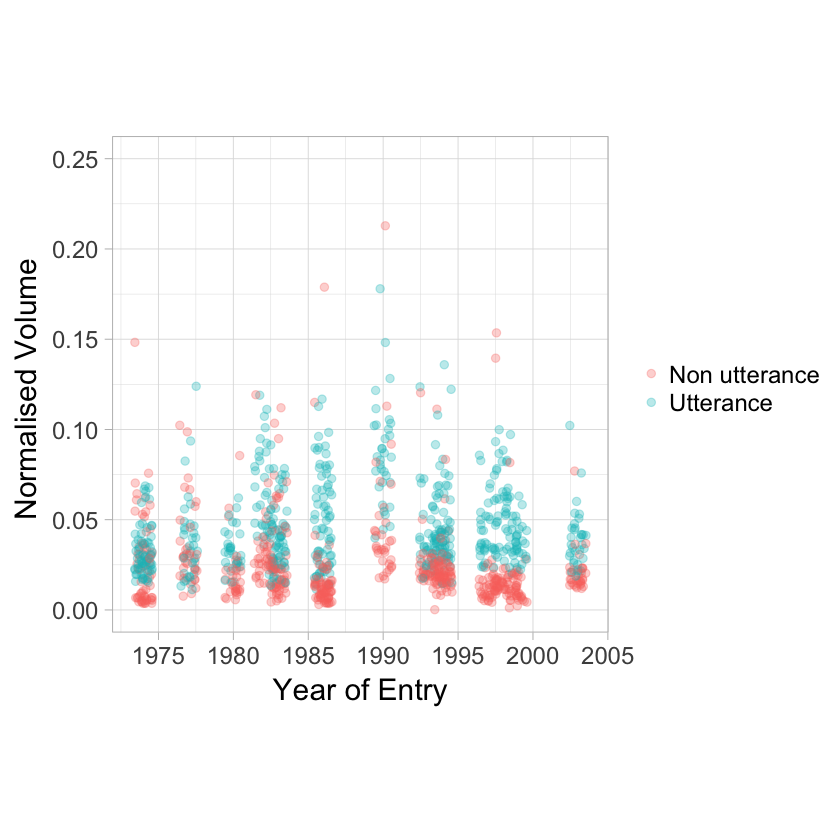

In [3]:
require(ggplot2)
bbox <- read.csv("bounding_box_data.csv")

cat("bounding box by year of entry")

p <- ggplot(bbox, aes(x = YoE, y = volume_m3, color = frame_type))+
geom_jitter(size = 2, alpha = 0.3 ,width = .6)+
#geom_smooth(method = "lm")+
scale_x_continuous(breaks = seq(1970,2005,by = 5))+
xlab("Year of Entry")+
ylab(expression(paste("Normalised Volume ")))+
ylim(c(0,0.25))+
theme_light(base_size = 18)+
theme(legend.title = element_blank(), aspect.ratio=1)

p
ggsave("plots/bounding_box_plot_noline.jpeg", p)

In [67]:
head(bbox)

X,Signer,segment,length,height,width,box_centre_X,box_centre_Y,box_centre_Z,frame_type,volume_cm3,volume_m3,cohort,YoE,YoE_centered
1,145,1,44.12153,39.81542,23.43968,4.1543719,27.05273,34.02032,Non utterance,41176.88,0.04117688,2,1990,16
2,145,2,60.66295,48.58833,19.71437,4.0268206,18.59255,28.16856,Utterance,58108.32,0.05810832,2,1990,16
3,145,1,56.74205,51.59898,19.44239,5.5419377,17.03394,30.81208,Utterance,56924.04,0.05692404,2,1990,16
4,145,3,37.41450,38.13664,12.04355,2.5895968,25.22810,26.45386,Non utterance,17184.49,0.01718449,2,1990,16
5,145,4,71.80234,52.40963,47.28846,4.0785286,19.96150,27.11376,Utterance,177952.83,0.17795283,2,1990,16
6,145,2,45.10204,40.06893,17.69594,0.6433285,28.82841,26.12030,Non utterance,31979.93,0.03197993,2,1990,16


In [69]:
require(lme4)

#predictor variable is centered so intercept is the earliest year of entry in our dataset. 
bbox$YoE_centered <- bbox$YoE - min(bbox$YoE)

#frame type sum-coded so comparison is to the mean (intercept refers to the mean?)
contrasts(bbox$frame_type) = contr.sum(2)
contrasts(bbox$frame_type)

full_mdl <- lmer(volume_m3 ~ YoE_centered + frame_type + YoE_centered:frame_type + (1|Signer), data = bbox)
mdl <- lmer(volume_m3 ~ YoE_centered + frame_type + (1|Signer), data = bbox)
null_mdl <- lmer(volume_m3 ~ (1|Signer), data = bbox)

YoE_only <- lmer(volume_m3 ~ YoE_centered +  (1|Signer), data = bbox)
frame_type_only <- lmer(volume_m3 ~ frame_type + (1|Signer), data = bbox)

summary(full_mdl)

cat("overall")
anova(full_mdl, null_mdl)

cat("effect of interaction?")
anova(full_mdl, mdl)

cat("main effect of frame type?")
anova(full_mdl, YoE_only)

cat("main effect of YoE?")
anova(full_mdl, frame_type_only)



Non utterance,1
Utterance,-1


Linear mixed model fit by REML ['lmerMod']
Formula: volume_m3 ~ YoE_centered + frame_type + YoE_centered:frame_type +  
    (1 | Signer)
   Data: bbox

REML criterion at convergence: -4666.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2660 -0.4442 -0.1932  0.1982 16.8610 

Random effects:
 Groups   Name        Variance  Std.Dev.
 Signer   (Intercept) 0.0001152 0.01073 
 Residual             0.0008813 0.02969 
Number of obs: 1133, groups:  Signer, 17

Fixed effects:
                           Estimate Std. Error t value
(Intercept)               0.0377922  0.0051509   7.337
YoE_centered             -0.0001064  0.0003145  -0.338
frame_type1              -0.0037330  0.0016739  -2.230
YoE_centered:frame_type1 -0.0004543  0.0001011  -4.495

Correlation of Fixed Effects:
            (Intr) YE_cnt frm_t1
YoE_centerd -0.846              
frame_type1  0.006 -0.005       
YE_cntrd:_1 -0.005  0.004 -0.850

overall

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
null_mdl,3,-4571.013,-4555.915,2288.507,-4577.013,NA,NA,NA
full_mdl,6,-4707.895,-4677.699,2359.947,-4719.895,142.8817,3,9.038003e-31


effect of interaction?

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
mdl,5,-4689.831,-4664.668,2349.915,-4699.831,NA,NA,NA
full_mdl,6,-4707.895,-4677.699,2359.947,-4719.895,20.06409,1,7.488962e-06


main effect of frame type?

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
YoE_only,4,-4569.153,-4549.023,2288.577,-4577.153,NA,NA,NA
full_mdl,6,-4707.895,-4677.699,2359.947,-4719.895,142.7419,2,1.009232e-31


main effect of YoE?

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
frame_type_only,4,-4691.715,-4671.584,2349.857,-4699.715,NA,NA,NA
full_mdl,6,-4707.895,-4677.699,2359.947,-4719.895,20.18044,2,4.148334e-05


# Bounding Box Utterance Only

In [21]:
require(ggplot2)
bbox <- read.csv("bounding_box_data.csv")
head(bbox)

X,Signer,segment,length,height,width,box_centre_X,box_centre_Y,box_centre_Z,frame_type,volume_cm3,volume_m3,cohort,YoE
1,145,1,44.12153,39.81542,23.43968,4.1543719,27.05273,34.02032,Non utterance,41176.88,0.04117688,2,1990
2,145,2,60.66295,48.58833,19.71437,4.0268206,18.59255,28.16856,Utterance,58108.32,0.05810832,2,1990
3,145,1,56.74205,51.59898,19.44239,5.5419377,17.03394,30.81208,Utterance,56924.04,0.05692404,2,1990
4,145,3,37.41450,38.13664,12.04355,2.5895968,25.22810,26.45386,Non utterance,17184.49,0.01718449,2,1990
5,145,4,71.80234,52.40963,47.28846,4.0785286,19.96150,27.11376,Utterance,177952.83,0.17795283,2,1990
6,145,2,45.10204,40.06893,17.69594,0.6433285,28.82841,26.12030,Non utterance,31979.93,0.03197993,2,1990


bounding box by year of entry

Saving 8 x 7 in image


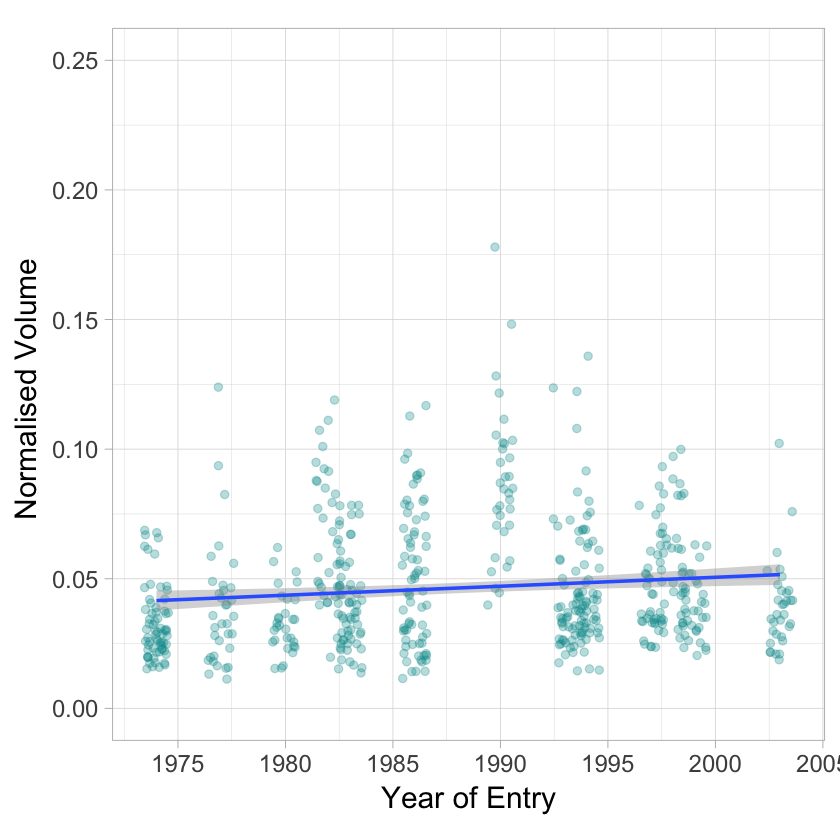

In [32]:
require(ggplot2)
bbox <- read.csv("bounding_box_data.csv")

cat("bounding box by year of entry")

p <- ggplot(subset(bbox, frame_type == "Utterance"), aes(x = YoE, y = volume_m3))+
geom_jitter(size = 2, alpha = 0.3 ,width = .6, color = "#009999")+
geom_smooth(method = "lm")+
scale_x_continuous(breaks = seq(1970,2005,by = 5))+
xlab("Year of Entry")+
ylab(expression(paste("Normalised Volume ")))+
ylim(c(0,0.25))+
theme_light(base_size = 18)+
theme(legend.title = element_blank(), aspect.ratio=1)

p

ggsave("bounding_box_plot_May.jpeg", width = 8, p)


In [34]:
min(subset(bbox, frame_type == "Utterance")$volume_m3)
max(subset(bbox, frame_type == "Utterance")$volume_m3)


[1] 0.01130684

[1] 0.1779528

In [23]:
require(lme4)

#predictor variable is centered so intercept is the earliest year of entry in our dataset. 
bbox$YoE_centered <- bbox$YoE - min(bbox$YoE)


full_mdl <- lmer(volume_m3 ~ YoE_centered + (1|Signer), subset(bbox, frame_type == "Utterance"))
null_mdl <- lmer(volume_m3 ~ (1|Signer), subset(bbox, frame_type == "Utterance"))

summary(full_mdl)

cat("model better than chance?")
anova(full_mdl, null_mdl)


Linear mixed model fit by REML ['lmerMod']
Formula: volume_m3 ~ YoE_centered + (1 | Signer)
   Data: subset(bbox, frame_type == "Utterance")

REML criterion at convergence: -2789.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3722 -0.6454 -0.1837  0.5059  4.7403 

Random effects:
 Groups   Name        Variance  Std.Dev.
 Signer   (Intercept) 0.0002397 0.01548 
 Residual             0.0003860 0.01965 
Number of obs: 570, groups:  Signer, 17

Fixed effects:
              Estimate Std. Error t value
(Intercept)  0.0414754  0.0071966   5.763
YoE_centered 0.0003456  0.0004398   0.786

Correlation of Fixed Effects:
            (Intr)
YoE_centerd -0.845

model better than chance?

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
null_mdl,3,-2805.506,-2792.469,1405.753,-2811.506,NA,NA,NA
full_mdl,4,-2804.192,-2786.809,1406.096,-2812.192,0.6859218,1,0.407555


## DISTANCE  (BODY-WRIST)

In [5]:
setwd("/Users/Asha/Flaherty_Sato_Kirby_2020")
list.files()



[1] "body_wrist_distances.csv"          "bounding_box_data.csv"            
[3] "mp_distance_plot.jpeg"             "plots"                            
[5] "utterance_glosses.csv"             "whole_session_data_scaled.csv"    
[7] "whole_session_data_scaled.csv.zip" "whole_session_data_segmented.csv" 
[9] "year_of_entry.csv"

In [13]:
body_data <- read.csv("whole_session_data_segmented.csv")
head(body_data,3)

frame,id,X,TimeStamp,skeletonID,HIP_CENTER_X,HIP_CENTER_Y,HIP_CENTER_Z,HIP_CENTER_TRACKSTATE,SPINE_X,⋯,HANDTIP_RIGHT_Z,HANDTIP_RIGHT_TRACKSTATE,THUMB_RIGHT_X,THUMB_RIGHT_Y,THUMB_RIGHT_Z,THUMB_RIGHT_TRACKSTATE,ppt,utterance_number,is_utterance,segment_number
1,27,95757,0,p27,1.0822322,47.14464,12.35252,2,0.1706741,⋯,65.84434,2,2.582145,-6.50609,55.91675,2,27,NA,0,538
2,27,95758,330000,p27,1.0267540,47.14464,12.31889,2,0.1706741,⋯,65.55738,2,2.582145,-6.50609,55.84663,2,27,NA,0,538
3,27,95759,660000,p27,0.9836366,47.14464,12.34791,2,0.1830348,⋯,65.25899,2,2.594505,-6.50609,55.77650,2,27,NA,0,538


In [200]:
# body-wrist distance is calculated from the origin (0,0,0) of the body data. 
# This corresponds to the Kinect SHOULDER_CENTER tracked joint between the shoulders.

# Pythagoras -the distance d between two points a and b in 3D space is given by
# d = sqrt((ax-bx)^2+(ay-by)^2+(az-bz)^2) 



body_data$left_body_wrist_dist <- sqrt( (body_data$WRIST_LEFT_X - body_data$SHOULDER_CENTER_X)^2 +
                                      (body_data$WRIST_LEFT_Y - body_data$SHOULDER_CENTER_Y)^2+
                                      (body_data$WRIST_LEFT_Z - body_data$SHOULDER_CENTER_Z)^2 )

body_data$right_body_wrist_dist <- sqrt( (body_data$WRIST_RIGHT_X - body_data$SHOULDER_CENTER_X)^2 +
                                      (body_data$WRIST_RIGHT_Y - body_data$SHOULDER_CENTER_Y)^2+
                                      (body_data$WRIST_RIGHT_Z - body_data$SHOULDER_CENTER_Z)^2 )



head(body_data,3)

frame,id,X,TimeStamp,skeletonID,HIP_CENTER_X,HIP_CENTER_Y,HIP_CENTER_Z,HIP_CENTER_TRACKSTATE,SPINE_X,⋯,THUMB_RIGHT_X,THUMB_RIGHT_Y,THUMB_RIGHT_Z,THUMB_RIGHT_TRACKSTATE,ppt,utterance_number,is_utterance,segment_number,left_body_wrist_dist,right_body_wrist_dist
1,27,95757,0,p27,1.0822322,47.14464,12.35252,2,0.1706741,⋯,2.582145,-6.50609,55.91675,2,27,NA,0,538,52.41598,42.39771
2,27,95758,330000,p27,1.0267540,47.14464,12.31889,2,0.1706741,⋯,2.582145,-6.50609,55.84663,2,27,NA,0,538,51.76476,42.32824
3,27,95759,660000,p27,0.9836366,47.14464,12.34791,2,0.1830348,⋯,2.594505,-6.50609,55.77650,2,27,NA,0,538,51.18707,42.26046


In [201]:
# get average distance of the wrists from origin

body_data$mean_body_wrist_dist <-rowMeans(body_data[,c("left_body_wrist_dist", "right_body_wrist_dist")])
head(body_data,3)

frame,id,X,TimeStamp,skeletonID,HIP_CENTER_X,HIP_CENTER_Y,HIP_CENTER_Z,HIP_CENTER_TRACKSTATE,SPINE_X,⋯,THUMB_RIGHT_Y,THUMB_RIGHT_Z,THUMB_RIGHT_TRACKSTATE,ppt,utterance_number,is_utterance,segment_number,left_body_wrist_dist,right_body_wrist_dist,mean_body_wrist_dist
1,27,95757,0,p27,1.0822322,47.14464,12.35252,2,0.1706741,⋯,-6.50609,55.91675,2,27,NA,0,538,52.41598,42.39771,47.40684
2,27,95758,330000,p27,1.0267540,47.14464,12.31889,2,0.1706741,⋯,-6.50609,55.84663,2,27,NA,0,538,51.76476,42.32824,47.04650
3,27,95759,660000,p27,0.9836366,47.14464,12.34791,2,0.1830348,⋯,-6.50609,55.77650,2,27,NA,0,538,51.18707,42.26046,46.72376


In [202]:
# aggregate body wrist distance by segment

body_data$is_utterance <- as.factor(body_data$is_utterance)

#utterance data 
utterance_distances <- aggregate(subset(body_data, is_utterance == 1)[,c("left_body_wrist_dist", "right_body_wrist_dist", "mean_body_wrist_dist")], by = list(subset(body_data, is_utterance == 1)$id, subset(body_data, is_utterance == 1)$segment_number), FUN = mean)
colnames(utterance_distances) <- c("Signer", "segment_number", "left_body_wrist_dist", "right_body_wrist_dist", "mean_body_wrist_dist")
utterance_distances$is_utterance <- "Utterance"
# head(utterance_distances)
# nrow(utterance_distances)

#non-utterance data
non_utterance_distances <- aggregate(subset(body_data, is_utterance == 0)[,c("left_body_wrist_dist", "right_body_wrist_dist", "mean_body_wrist_dist")], by = list(subset(body_data, is_utterance == 0)$id, subset(body_data, is_utterance == 0)$segment_number), FUN = mean)
colnames(non_utterance_distances) <- c("Signer", "segment_number", "left_body_wrist_dist", "right_body_wrist_dist", "mean_body_wrist_dist")
non_utterance_distances$is_utterance <- "Non Utterance"
# head(non_utterance_distances)
# nrow(non_utterance_distances)

#join
body_wrist_distances <- rbind(utterance_distances, non_utterance_distances)
head(body_wrist_distances,3)
tail(body_wrist_distances, 3)

Signer,segment_number,left_body_wrist_dist,right_body_wrist_dist,mean_body_wrist_dist,is_utterance
145,1,39.86827,39.19539,39.53183,Utterance
145,2,40.21379,45.15840,42.68610,Utterance
145,3,39.76624,41.71999,40.74311,Utterance


,Signer,segment_number,left_body_wrist_dist,right_body_wrist_dist,mean_body_wrist_dist,is_utterance
1148,27,570,48.67766,45.08866,46.88316,Non Utterance
1149,27,571,45.27871,46.66398,45.97134,Non Utterance
1150,36,571,52.26955,53.52085,52.89520,Non Utterance


In [203]:
#merge with Year of Entry
YoE <- read.csv("year_of_entry.csv")
body_wrist_distances <- merge(YoE,body_wrist_distances)
head(body_wrist_distances,3)

Signer,cohort,YoE,segment_number,left_body_wrist_dist,right_body_wrist_dist,mean_body_wrist_dist,is_utterance
27,1,1977,557,52.16559,50.46256,51.31407,Non Utterance
27,1,1977,571,41.82662,44.43284,43.12973,Utterance
27,1,1977,539,51.37429,49.12567,50.24998,Utterance


In [209]:
#write.csv(body_wrist_distances, "body_wrist_distances.csv")

In [211]:
cat("min distance:")
min(body_wrist_distances$mean_body_wrist_dist)

cat("max distance:")
max(body_wrist_distances$mean_body_wrist_dist)

min distance:

[1] 23.11704

max distance:

[1] 56.54722

In [224]:
body_wrist_distances[order(body_wrist_distances$mean_body_wrist_dist),]

,Signer,cohort,YoE,segment_number,left_body_wrist_dist,right_body_wrist_dist,mean_body_wrist_dist,is_utterance,YoE_centered
168,41,1,1974,302,23.88060,22.35349,23.11704,Non Utterance,0
1068,420,3,1999,259,21.50735,25.08338,23.29536,Utterance,25
520,191,1,1983,119,20.07427,29.26891,24.67159,Utterance,9
691,264,3,1994,371,28.26216,28.93004,28.59610,Utterance,20
717,264,3,1994,385,28.14682,29.53658,28.84170,Utterance,20
1028,420,3,1999,248,25.40445,33.31104,29.35774,Utterance,25
699,264,3,1994,392,25.43746,33.33454,29.38600,Utterance,20
683,264,3,1994,372,27.96448,31.42671,29.69559,Utterance,20
675,264,3,1994,374,29.49257,30.11337,29.80297,Utterance,20
685,264,3,1994,391,30.18796,30.05726,30.12261,Utterance,20


body wrist distance by year of entry

Saving 7 x 7 in image


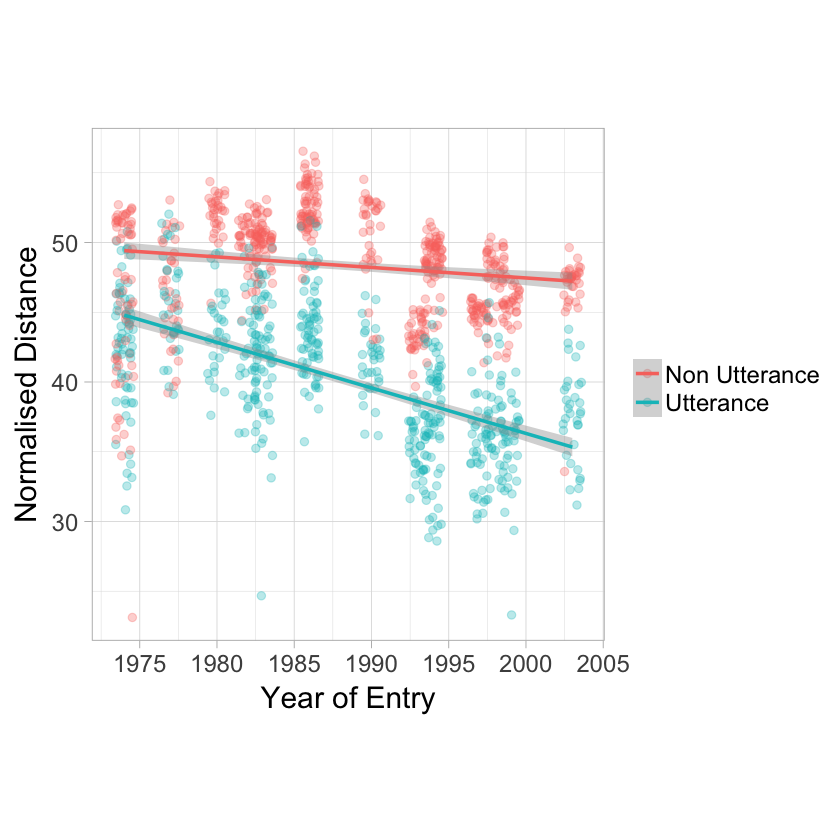

In [71]:
require(ggplot2)

cat("body wrist distance by year of entry")

p <- ggplot(body_wrist_distances, aes(x = YoE, y = mean_body_wrist_dist, color = is_utterance))+
geom_jitter(size = 2, alpha = 0.3 ,width = .6)+
geom_smooth(method = "lm")+
scale_x_continuous(breaks = seq(1970,2005,by = 5))+
xlab("Year of Entry")+
ylab("Normalised Distance")+
theme_light(base_size = 18)+
theme(legend.title = element_blank(), aspect.ratio=1)

p
ggsave("plots/bw_distance_plot.jpeg", p)

In [12]:
body_wrist_distances <- read.csv("body_wrist_distances.csv")
head(body_wrist_distances)

X,Signer,cohort,YoE,segment_number,left_body_wrist_dist,right_body_wrist_dist,mean_body_wrist_dist,is_utterance,YoE_centered
1,27,1,1977,557,52.16559,50.46256,51.31407,Non Utterance,3
2,27,1,1977,571,41.82662,44.43284,43.12973,Utterance,3
3,27,1,1977,539,51.37429,49.12567,50.24998,Utterance,3
4,27,1,1977,558,51.41659,50.29014,50.85337,Non Utterance,3
5,27,1,1977,559,37.61058,41.75956,39.68507,Non Utterance,3
6,27,1,1977,538,45.72059,41.16292,43.44176,Utterance,3


In [11]:
#stats

require("lme4")

#predictor variable is centered so intercept is the earliest year of entry in our dataset. 
body_wrist_distances$YoE_centered <- body_wrist_distances$YoE - min(body_wrist_distances$YoE)

#frame type sum-coded so comparison is to the mean (intercept refers to the mean?)
contrasts(body_wrist_distances$is_utterance) = contr.sum(2)
contrasts(body_wrist_distances$is_utterance)

full_mdl <- lmer(mean_body_wrist_dist ~ YoE_centered + is_utterance +  YoE_centered:is_utterance +(1|Signer), data = body_wrist_distances)
mdl <- lmer(mean_body_wrist_dist ~ YoE_centered + is_utterance +(1|Signer), data = body_wrist_distances)

YoE_only <- lmer(mean_body_wrist_dist ~ YoE_centered +(1|Signer), data = body_wrist_distances)
frame_type_only <- lmer(mean_body_wrist_dist ~ is_utterance +(1|Signer), data = body_wrist_distances)

null_mdl <- lmer(mean_body_wrist_dist ~ (1|Signer), data = body_wrist_distances)

summary(full_mdl)

cat("overall")
anova(full_mdl, null_mdl)

cat("effect of interaction?")
anova(full_mdl, mdl)

cat("main effect of frame type?")
anova(full_mdl, YoE_only)

cat("main effect of YoE?")
anova(full_mdl, frame_type_only)



Non Utterance,1
Utterance,-1


Linear mixed model fit by REML ['lmerMod']
Formula: 
mean_body_wrist_dist ~ YoE_centered + is_utterance + YoE_centered:is_utterance +  
    (1 | Signer)
   Data: body_wrist_distances

REML criterion at convergence: 5855.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.0036 -0.4916  0.0895  0.5708  2.8785 

Random effects:
 Groups   Name        Variance Std.Dev.
 Signer   (Intercept) 7.340    2.709   
 Residual             8.909    2.985   
Number of obs: 1150, groups:  Signer, 17

Fixed effects:
                           Estimate Std. Error t value
(Intercept)                47.01126    1.24096   37.88
YoE_centered               -0.19538    0.07586   -2.58
is_utterance1               2.32207    0.16712   13.89
YoE_centered:is_utterance1  0.12483    0.01008   12.38

Correlation of Fixed Effects:
            (Intr) YE_cnt is_tt1
YoE_centerd -0.845              
is_utternc1  0.000  0.000       
YE_cntrd:_1  0.000 -0.001 -0.850

overall

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
null_mdl,3,7113.265,7128.408,-3553.633,7107.265,NA,NA,NA
full_mdl,6,5855.134,5885.419,-2921.567,5843.134,1264.131,3,8.923991e-274


effect of interaction?

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
mdl,5,5997.210,6022.447,-2993.605,5987.210,NA,NA,NA
full_mdl,6,5855.134,5885.419,-2921.567,5843.134,144.0755,1,3.420483e-33


main effect of frame type?

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
YoE_only,4,7109.312,7129.502,-3550.656,7101.312,NA,NA,NA
full_mdl,6,5855.134,5885.419,-2921.567,5843.134,1258.178,2,6.168913e-274


main effect of YoE?

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
frame_type_only,4,6001.394,6021.584,-2996.697,5993.394,NA,NA,NA
full_mdl,6,5855.134,5885.419,-2921.567,5843.134,150.2603,2,2.351755e-33


# Body Wirst Distance Utterances Only


In [41]:
body_wrist_distances <- read.csv("body_wrist_distances.csv")
head(body_wrist_distances)

min(subset(body_wrist_distances, is_utterance == "Utterance")$mean_body_wrist_dist)
max(subset(body_wrist_distances, is_utterance == "Utterance")$mean_body_wrist_dist)

X,Signer,cohort,YoE,segment_number,left_body_wrist_dist,right_body_wrist_dist,mean_body_wrist_dist,is_utterance,YoE_centered
1,27,1,1977,557,52.16559,50.46256,51.31407,Non Utterance,3
2,27,1,1977,571,41.82662,44.43284,43.12973,Utterance,3
3,27,1,1977,539,51.37429,49.12567,50.24998,Utterance,3
4,27,1,1977,558,51.41659,50.29014,50.85337,Non Utterance,3
5,27,1,1977,559,37.61058,41.75956,39.68507,Non Utterance,3
6,27,1,1977,538,45.72059,41.16292,43.44176,Utterance,3


[1] 23.29536

[1] 52.03503

body wrist distance by year of entry

Saving 8 x 7 in image


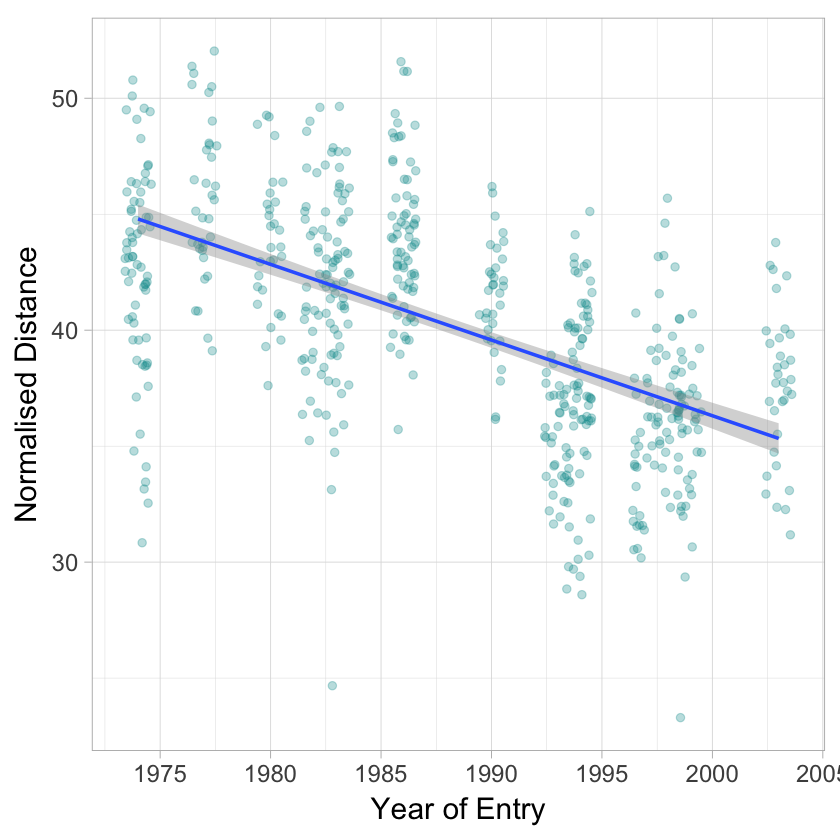

In [38]:
require(ggplot2)

cat("body wrist distance by year of entry")

p <- ggplot(subset(body_wrist_distances, is_utterance == "Utterance"), aes(x = YoE, y = mean_body_wrist_dist))+
geom_jitter(size = 2, alpha = 0.3 ,width = .6, color = "#009999")+
geom_smooth(method = "lm")+
scale_x_continuous(breaks = seq(1970,2005,by = 5))+
xlab("Year of Entry")+
ylab("Normalised Distance")+
theme_light(base_size = 18)+
theme(legend.title = element_blank(), aspect.ratio=1)

p
 ggsave("bw_distance_plot.jpeg", width = 8, p)

In [17]:
#stats

require("lme4")

#predictor variable is centered so intercept is the earliest year of entry in our dataset. 
body_wrist_distances$YoE_centered <- body_wrist_distances$YoE - min(body_wrist_distances$YoE)


full_mdl <- lmer(mean_body_wrist_dist ~ YoE_centered +(1|Signer), subset(body_wrist_distances, is_utterance == "Utterance"))
null_mdl <- lmer(mean_body_wrist_dist ~ (1|Signer), subset(body_wrist_distances, is_utterance == "Utterance"))

summary(full_mdl)

cat("overall")
anova(full_mdl, null_mdl)

Linear mixed model fit by REML ['lmerMod']
Formula: mean_body_wrist_dist ~ YoE_centered + (1 | Signer)
   Data: subset(body_wrist_distances, is_utterance == "Utterance")

REML criterion at convergence: 3021.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.6797 -0.6708  0.0027  0.6605  2.4113 

Random effects:
 Groups   Name        Variance Std.Dev.
 Signer   (Intercept)  6.209   2.492   
 Residual             10.716   3.274   
Number of obs: 570, groups:  Signer, 17

Fixed effects:
             Estimate Std. Error t value
(Intercept)  44.67716    1.16026   38.51
YoE_centered -0.32038    0.07091   -4.52

Correlation of Fixed Effects:
            (Intr)
YoE_centerd -0.845

overall

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
null_mdl,3,3039.212,3052.249,-1516.606,3033.212,NA,NA,NA
full_mdl,4,3026.621,3044.004,-1509.311,3018.621,14.5909,1,0.0001335578


## DISTANCE  (MEAN POSITION OF THE WRISTS)

In [1]:
setwd("/Users/Asha/Flaherty_Sato_Kirby_2020")
list.files()


[1] "body_wrist_distances.csv"          "bounding_box_data.csv"            
 [3] "mp_distance_plot.jpeg"             "mp_distances.csv"                 
 [5] "plots"                             "utterance_glosses.csv"            
 [7] "whole_session_data_scaled.csv"     "whole_session_data_scaled.csv.zip"
 [9] "whole_session_data_segmented.csv"  "year_of_entry.csv"

In [2]:
body_data <- read.csv("whole_session_data_segmented.csv")
head(body_data,3)

frame,id,X,TimeStamp,skeletonID,HIP_CENTER_X,HIP_CENTER_Y,HIP_CENTER_Z,HIP_CENTER_TRACKSTATE,SPINE_X,⋯,HANDTIP_RIGHT_Z,HANDTIP_RIGHT_TRACKSTATE,THUMB_RIGHT_X,THUMB_RIGHT_Y,THUMB_RIGHT_Z,THUMB_RIGHT_TRACKSTATE,ppt,utterance_number,is_utterance,segment_number
1,27,95757,0,p27,1.0822322,47.14464,12.35252,2,0.1706741,⋯,65.84434,2,2.582145,-6.50609,55.91675,2,27,NA,0,538
2,27,95758,330000,p27,1.0267540,47.14464,12.31889,2,0.1706741,⋯,65.55738,2,2.582145,-6.50609,55.84663,2,27,NA,0,538
3,27,95759,660000,p27,0.9836366,47.14464,12.34791,2,0.1830348,⋯,65.25899,2,2.594505,-6.50609,55.77650,2,27,NA,0,538


In [3]:
# find the mean position of the wrists of each signer over the whole session, 
# we also get the mean position of the wrists separately for utterance data and non-utterance data
# as we expect these to be differently distributed.

#empty vectors for storing values
ids <- c()
mean_x_pos <- c()
mean_y_pos <- c()
mean_z_pos <- c()

utt_x_pos <- c()
utt_y_pos <- c()
utt_z_pos <- c()

non_utt_x_pos <- c()
non_utt_y_pos <- c()
non_utt_z_pos <- c()

#colnames(body_data)
for (signer in unique(body_data$id)) {
    iD <- signer
#      print(iD)
     df <- subset(body_data, ppt == iD)
    
     #whole session mean positions:
    
     mean_x <- mean(c(df$WRIST_LEFT_X, df$WRIST_RIGHT_X))
     mean_y <- mean(c(df$WRIST_LEFT_Y, df$WRIST_RIGHT_Y))
     mean_z <- mean(c(df$WRIST_LEFT_Z, df$WRIST_RIGHT_Z))
    
     utt_x <- mean(c(subset(df, is_utterance == 1)$WRIST_LEFT_X, (subset(df, is_utterance == 1)$WRIST_RIGHT_X)))
     utt_y <- mean(c(subset(df, is_utterance == 1)$WRIST_LEFT_Y, (subset(df, is_utterance == 1)$WRIST_RIGHT_Y)))
     utt_z <- mean(c(subset(df, is_utterance == 1)$WRIST_LEFT_Z, (subset(df, is_utterance == 1)$WRIST_RIGHT_Z)))

     non_utt_x <- mean(c(subset(df, is_utterance == 0)$WRIST_LEFT_X, (subset(df, is_utterance == 0)$WRIST_RIGHT_X)))
     non_utt_y <- mean(c(subset(df, is_utterance == 0)$WRIST_LEFT_Y, (subset(df, is_utterance == 0)$WRIST_RIGHT_Y)))
     non_utt_z <- mean(c(subset(df, is_utterance == 0)$WRIST_LEFT_Z, (subset(df, is_utterance == 0)$WRIST_RIGHT_Z)))
   
                   
#     #add to vectors
    ids <- c(ids, iD)
    
    mean_x_pos <- c(mean_x_pos, mean_x)
    mean_y_pos <- c(mean_y_pos, mean_y)
    mean_z_pos <- c(mean_z_pos, mean_z)
    
    utt_x_pos <- c(utt_x_pos, utt_x)
    utt_y_pos <- c(utt_y_pos, utt_y)
    utt_z_pos <- c(utt_z_pos, utt_z)

    non_utt_x_pos <- c(non_utt_x_pos, non_utt_x)
    non_utt_y_pos <- c(non_utt_y_pos, non_utt_y)
    non_utt_z_pos <- c(non_utt_z_pos, non_utt_z)
      
}

mean_wrist_positions <- as.data.frame(cbind("Signer" = ids, 
                                            "mean_x" = mean_x_pos,
                                           "mean_y" = mean_y_pos,
                                           "mean_z" = mean_z_pos,
                                           "utt_mean_x" = utt_x_pos,
                                           "utt_mean_y" = utt_y_pos,
                                           "utt_mean_z" = utt_z_pos,
                                           "non_utt_mean_x" = non_utt_x_pos,
                                           "non_utt_mean_y" = non_utt_y_pos,
                                           "non_utt_mean_z" = non_utt_z_pos
                                           ))

head(mean_wrist_positions)


Signer,mean_x,mean_y,mean_z,utt_mean_x,utt_mean_y,utt_mean_z,non_utt_mean_x,non_utt_mean_y,non_utt_mean_z
27,3.4841348,29.60389,30.42871,3.43840633,29.07597,30.47875,3.5273539,30.10284,30.38141
36,1.6544830,36.43440,26.74215,1.16393488,28.72018,27.60861,1.8803037,39.98559,26.34328
41,-0.6666407,30.50464,30.64336,-0.84180809,26.39725,33.58869,-0.4971052,34.47996,27.79274
49,0.2940719,30.18718,28.85032,-0.04722237,17.49275,32.55606,0.5206075,38.61316,26.39061
145,3.4719842,30.91175,28.49754,3.87954259,19.44281,29.95835,3.2204451,37.99021,27.59595
158,0.1432539,35.71954,24.83047,-1.35495970,28.33478,26.63402,1.3089446,41.46528,23.42721


In [4]:
# note that the mean position (height) of the wrists is significantly different for utterance data and non-utterance data:
t.test(mean_wrist_positions$utt_mean_y, mean_wrist_positions$non_utt_mean_y)


	Welch Two Sample t-test

data:  mean_wrist_positions$utt_mean_y and mean_wrist_positions$non_utt_mean_y
t = -8.3147, df = 30.893, p-value = 2.22e-09
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -18.41195 -11.15774
sample estimates:
mean of x mean of y 
 21.19877  35.98362 


In [5]:
# merge with Year of Entry
YoE <- read.csv("year_of_entry.csv")
mean_wrist_positions <- merge(YoE,mean_wrist_positions)
head(mean_wrist_positions,3)

Signer,cohort,YoE,mean_x,mean_y,mean_z,utt_mean_x,utt_mean_y,utt_mean_z,non_utt_mean_x,non_utt_mean_y,non_utt_mean_z
27,1,1977,3.4841348,29.60389,30.42871,3.4384063,29.07597,30.47875,3.5273539,30.10284,30.38141
36,1,1980,1.6544830,36.43440,26.74215,1.1639349,28.72018,27.60861,1.8803037,39.98559,26.34328
41,1,1974,-0.6666407,30.50464,30.64336,-0.8418081,26.39725,33.58869,-0.4971052,34.47996,27.79274


In [6]:
# merge mean positions into body data

body_data <- merge(body_data, mean_wrist_positions, by.x = "id", by.y = "Signer")
head(body_data,3)

id,frame,X,TimeStamp,skeletonID,HIP_CENTER_X,HIP_CENTER_Y,HIP_CENTER_Z,HIP_CENTER_TRACKSTATE,SPINE_X,⋯,YoE,mean_x,mean_y,mean_z,utt_mean_x,utt_mean_y,utt_mean_z,non_utt_mean_x,non_utt_mean_y,non_utt_mean_z
27,1,95757,0,p27,1.0822322,47.14464,12.35252,2,0.1706741,⋯,1977,3.484135,29.60389,30.42871,3.438406,29.07597,30.47875,3.527354,30.10284,30.38141
27,2,95758,330000,p27,1.0267540,47.14464,12.31889,2,0.1706741,⋯,1977,3.484135,29.60389,30.42871,3.438406,29.07597,30.47875,3.527354,30.10284,30.38141
27,3,95759,660000,p27,0.9836366,47.14464,12.34791,2,0.1830348,⋯,1977,3.484135,29.60389,30.42871,3.438406,29.07597,30.47875,3.527354,30.10284,30.38141


In [7]:
# frame by frame distance to mean wrist position (mean of utterance or non utterance type accordingly)

# Pythagoras -the distance d between two points a and b in 3D space is given by
# d = sqrt((ax-bx)^2+(ay-by)^2+(az-bz)^2) 


body_data$left_mp_dist <- ifelse(body_data$is_utterance == 1,sqrt( (body_data$WRIST_LEFT_X - body_data$utt_mean_x)^2 +
                                      (body_data$WRIST_LEFT_Y - body_data$utt_mean_y)^2+
                                      (body_data$WRIST_LEFT_Z - body_data$utt_mean_z)^2 ),
                                  sqrt( (body_data$WRIST_LEFT_X - body_data$non_utt_mean_x)^2 +
                                      (body_data$WRIST_LEFT_Y - body_data$non_utt_mean_y)^2+
                                      (body_data$WRIST_LEFT_Z - body_data$non_utt_mean_z)^2 ))

body_data$right_mp_dist <- ifelse(body_data$is_utterance == 1,sqrt( (body_data$WRIST_RIGHT_X - body_data$utt_mean_x)^2 +
                                      (body_data$WRIST_RIGHT_Y - body_data$utt_mean_y)^2+
                                      (body_data$WRIST_RIGHT_Z - body_data$utt_mean_z)^2 ),
                                  sqrt( (body_data$WRIST_RIGHT_X - body_data$non_utt_mean_x)^2 +
                                      (body_data$WRIST_RIGHT_Y - body_data$non_utt_mean_y)^2+
                                      (body_data$WRIST_RIGHT_Z - body_data$non_utt_mean_z)^2 ))



# body_data$left_mp_dist <- sqrt( (body_data$WRIST_LEFT_X - body_data$mean_x)^2 +
#                                       (body_data$WRIST_LEFT_Y - body_data$mean_y)^2+
#                                       (body_data$WRIST_LEFT_Z - body_data$mean_z)^2 )

# body_data$right_mp_dist <- sqrt( (body_data$WRIST_RIGHT_X - body_data$mean_x)^2 +
#                                       (body_data$WRIST_RIGHT_Y - body_data$mean_y)^2+
#                                       (body_data$WRIST_RIGHT_Z - body_data$mean_z)^2 )

head(body_data,3)

id,frame,X,TimeStamp,skeletonID,HIP_CENTER_X,HIP_CENTER_Y,HIP_CENTER_Z,HIP_CENTER_TRACKSTATE,SPINE_X,⋯,mean_y,mean_z,utt_mean_x,utt_mean_y,utt_mean_z,non_utt_mean_x,non_utt_mean_y,non_utt_mean_z,left_mp_dist,right_mp_dist
27,1,95757,0,p27,1.0822322,47.14464,12.35252,2,0.1706741,⋯,29.60389,30.42871,3.438406,29.07597,30.47875,3.527354,30.10284,30.38141,25.65964,32.65339
27,2,95758,330000,p27,1.0267540,47.14464,12.31889,2,0.1706741,⋯,29.60389,30.42871,3.438406,29.07597,30.47875,3.527354,30.10284,30.38141,25.15926,32.62849
27,3,95759,660000,p27,0.9836366,47.14464,12.34791,2,0.1830348,⋯,29.60389,30.42871,3.438406,29.07597,30.47875,3.527354,30.10284,30.38141,24.68468,32.60458


In [8]:
# get average distance to mean position

body_data$mean_mp_dist <-rowMeans(body_data[,c("left_mp_dist", "right_mp_dist")])
head(body_data,3)

id,frame,X,TimeStamp,skeletonID,HIP_CENTER_X,HIP_CENTER_Y,HIP_CENTER_Z,HIP_CENTER_TRACKSTATE,SPINE_X,⋯,mean_z,utt_mean_x,utt_mean_y,utt_mean_z,non_utt_mean_x,non_utt_mean_y,non_utt_mean_z,left_mp_dist,right_mp_dist,mean_mp_dist
27,1,95757,0,p27,1.0822322,47.14464,12.35252,2,0.1706741,⋯,30.42871,3.438406,29.07597,30.47875,3.527354,30.10284,30.38141,25.65964,32.65339,29.15651
27,2,95758,330000,p27,1.0267540,47.14464,12.31889,2,0.1706741,⋯,30.42871,3.438406,29.07597,30.47875,3.527354,30.10284,30.38141,25.15926,32.62849,28.89388
27,3,95759,660000,p27,0.9836366,47.14464,12.34791,2,0.1830348,⋯,30.42871,3.438406,29.07597,30.47875,3.527354,30.10284,30.38141,24.68468,32.60458,28.64463


[1] 0 0 0 0 0 0

[1] 0 0 0 0 0 0
Levels: 0 1

In [22]:
# aggregate distance to mean position by segment 

body_data$is_utterance <- as.factor(body_data$is_utterance)

#utterance data 
utterance_distances <- aggregate(subset(body_data, is_utterance == 1)[,c("left_mp_dist", "right_mp_dist", "mean_mp_dist")], by = list(subset(body_data, is_utterance == 1)$id, subset(body_data, is_utterance == 1)$segment_number), FUN = mean)
colnames(utterance_distances) <- c("Signer", "segment_number", "left_mp_dist", "right_mp_dist", "mean_mp_dist")
utterance_distances$is_utterance <- "Utterance"
# head(utterance_distances)
# nrow(utterance_distances)

#non-utterance data
non_utterance_distances <- aggregate(subset(body_data, is_utterance == 0)[,c("left_mp_dist", "right_mp_dist", "mean_mp_dist")], by = list(subset(body_data, is_utterance == 0)$id, subset(body_data, is_utterance == 0)$segment_number), FUN = mean)
colnames(non_utterance_distances) <- c("Signer", "segment_number", "left_mp_dist", "right_mp_dist", "mean_mp_dist")
non_utterance_distances$is_utterance <- "Non Utterance"
# head(non_utterance_distances)
# nrow(non_utterance_distances)

#join
mp_distances <- rbind(utterance_distances, non_utterance_distances)
mp_distances <- merge(mp_distances, YoE)
head(mp_distances,3)
tail(mp_distances, 3)

Signer,segment_number,left_mp_dist,right_mp_dist,mean_mp_dist,is_utterance,cohort,YoE
27,553,14.67060,18.44290,16.55675,Utterance,1,1977
27,554,13.29758,15.72928,14.51343,Utterance,1,1977
27,557,14.57228,22.80012,18.68620,Utterance,1,1977


,Signer,segment_number,left_mp_dist,right_mp_dist,mean_mp_dist,is_utterance,cohort,YoE
1148,736,60,14.53088,8.193353,11.362118,Non Utterance,4,2003
1149,736,263,10.63639,9.328508,9.982447,Non Utterance,4,2003
1150,736,53,11.01724,10.105768,10.561506,Non Utterance,4,2003


In [23]:
cat("min distance:")
min(mp_distances$mean_mp_dist)

cat("max distance:")
max(mp_distances$mean_mp_dist)

min distance:

[1] 8.668248

max distance:

[1] 38.37807

In [24]:
write.csv(mp_distances, "mp_distances.csv")

In [4]:
mp_distances <- read.csv("mp_distances.csv")

# Average Distance utterances only

In [37]:
head(mp_distances)
min(subset(mp_distances, is_utterance == "Utterance")$mean_mp_dist)
max(subset(mp_distances, is_utterance == "Utterance")$mean_mp_dist)

X,Signer,segment_number,left_mp_dist,right_mp_dist,mean_mp_dist,is_utterance,cohort,YoE,YoE_centered
1,27,553,14.67060,18.44290,16.55675,Utterance,1,1977,3
2,27,554,13.29758,15.72928,14.51343,Utterance,1,1977,3
3,27,557,14.57228,22.80012,18.68620,Utterance,1,1977,3
4,27,558,15.52961,20.45033,17.98997,Utterance,1,1977,3
5,27,555,15.62553,17.47791,16.55172,Utterance,1,1977,3
6,27,552,17.77410,22.20480,19.98945,Utterance,1,1977,3


[1] 10.9108

[1] 26.05454

distance to mean position of wrists by year of entry

Saving 8 x 7 in image


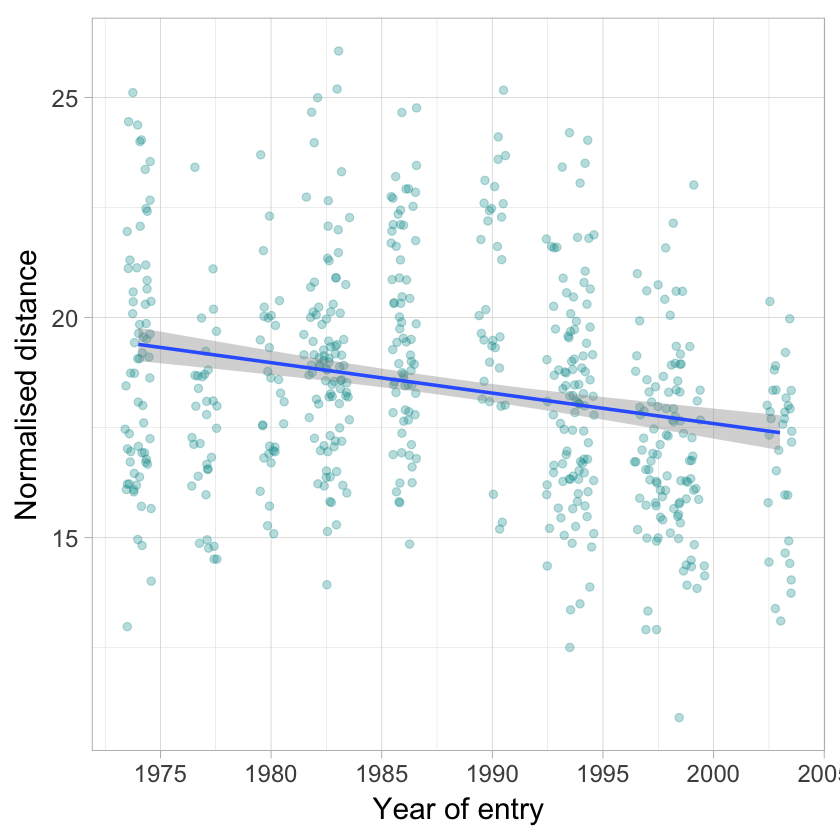

In [35]:
require(ggplot2)

cat("distance to mean position of wrists by year of entry")

p <- ggplot(subset(mp_distances, is_utterance == "Utterance"), aes(x = YoE, y = mean_mp_dist))+
geom_jitter(size = 2, alpha = 0.3 ,width = .6, color = "#009999")+
geom_smooth(method = lm)+
scale_x_continuous(breaks = seq(1970,2005,by = 5))+
xlab("Year of entry")+
ylab("Normalised distance")+
theme_light(base_size = 18)+
theme(legend.title = element_blank(), aspect.ratio=1)

p
 ggsave("mp_distance_plot.jpeg", width = 8, p)

In [18]:
#stats

require("lme4")

#predictor variable is centered so intercept is the earliest year of entry in our dataset. 
mp_distances$YoE_centered <- mp_distances$YoE - min(mp_distances$YoE)



full_mdl <- lmer(mean_mp_dist ~ YoE_centered +(1|Signer), subset(mp_distances, is_utterance == "Utterance"))
null_mdl <- lmer(mean_mp_dist ~ (1|Signer), subset(mp_distances, is_utterance == "Utterance"))

summary(full_mdl)

cat("Model better than chance?")
anova(full_mdl, null_mdl)


Linear mixed model fit by REML ['lmerMod']
Formula: mean_mp_dist ~ YoE_centered + (1 | Signer)
   Data: subset(mp_distances, is_utterance == "Utterance")

REML criterion at convergence: 2535.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4805 -0.6957 -0.0730  0.6356  3.3463 

Random effects:
 Groups   Name        Variance Std.Dev.
 Signer   (Intercept) 1.510    1.229   
 Residual             4.624    2.150   
Number of obs: 570, groups:  Signer, 17

Fixed effects:
             Estimate Std. Error t value
(Intercept)  19.42808    0.58313   33.32
YoE_centered -0.07131    0.03562   -2.00

Correlation of Fixed Effects:
            (Intr)
YoE_centerd -0.845

Model better than chance?

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
null_mdl,3,2540.483,2553.520,-1267.241,2534.483,NA,NA,NA
full_mdl,4,2538.457,2555.839,-1265.228,2530.457,4.026269,1,0.0447969


Loading required package: ggplot2


distance to mean position of wrists by year of entry

Saving 7 x 7 in image


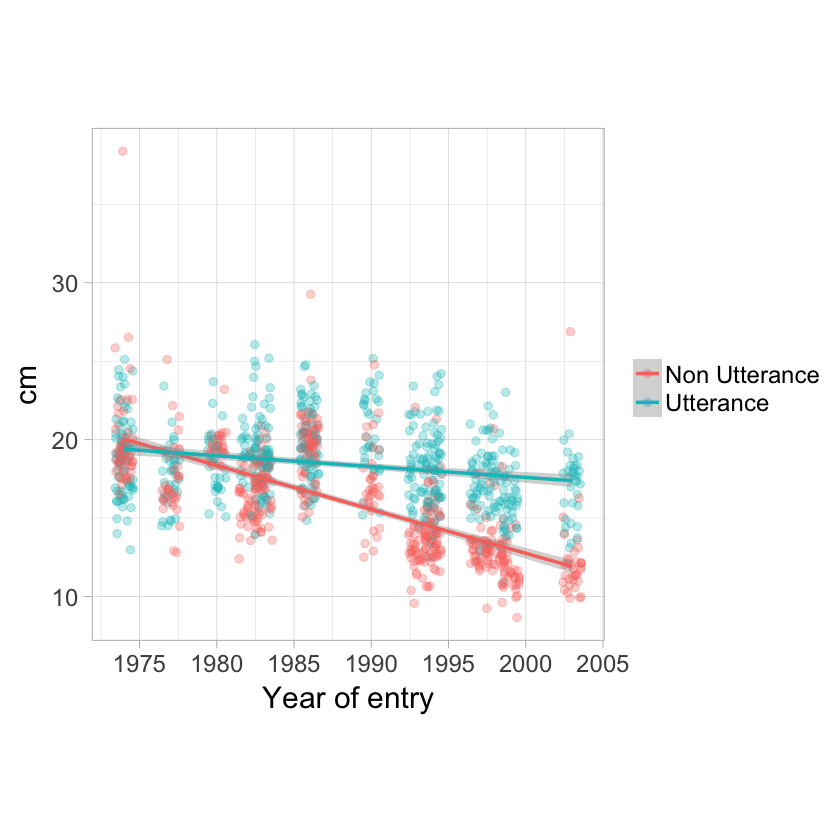

In [32]:
require(ggplot2)

cat("distance to mean position of wrists by year of entry")

p <- ggplot(mp_distances, aes(x = YoE, y = mean_mp_dist, color = is_utterance))+
geom_jitter(size = 2, alpha = 0.3 ,width = .6)+
geom_smooth(method = lm)+
scale_x_continuous(breaks = seq(1970,2005,by = 5))+
xlab("Year of entry")+
ylab("cm")+
theme_light(base_size = 18)+
theme(legend.title = element_blank(), aspect.ratio=1)

p
ggsave("mp_distance_plot.jpeg", p)

In [12]:
list.files()

[1] "body_wrist_distances.csv"          "bounding_box_data.csv"            
[3] "mp_distance_plot.jpeg"             "plots"                            
[5] "utterance_glosses.csv"             "whole_session_data_scaled.csv"    
[7] "whole_session_data_scaled.csv.zip" "whole_session_data_segmented.csv" 
[9] "year_of_entry.csv"

In [33]:
#stats

require("lme4")

#predictor variable is centered so intercept is the earliest year of entry in our dataset. 
mp_distances$YoE_centered <- mp_distances$YoE - min(mp_distances$YoE)

#frame type sum-coded so comparison is to the mean (intercept refers to the mean?)
contrasts(mp_distances$is_utterance) = contr.sum(2)
contrasts(mp_distances$is_utterance)

full_mdl <- lmer(mean_mp_dist ~ YoE_centered + is_utterance +  YoE_centered:is_utterance +(1|Signer), data = mp_distances)
mdl <- lmer(mean_mp_dist ~ YoE_centered + is_utterance +(1|Signer), data = mp_distances)

YoE_only <- lmer(mean_mp_dist ~ YoE_centered +(1|Signer), data = mp_distances)
frame_type_only <- lmer(mean_mp_dist ~ is_utterance +(1|Signer), data = mp_distances)

null_mdl <- lmer(mean_mp_dist ~ (1|Signer), data = mp_distances)

summary(full_mdl)

cat("overall")
anova(full_mdl, null_mdl)

cat("effect of interaction?")
anova(full_mdl, mdl)

cat("main effect of frame type?")
anova(full_mdl, YoE_only)

cat("main effect of YoE?")
anova(full_mdl, frame_type_only)

Non Utterance,1
Utterance,-1


Linear mixed model fit by REML ['lmerMod']
Formula: 
mean_mp_dist ~ YoE_centered + is_utterance + YoE_centered:is_utterance +  
    (1 | Signer)
   Data: mp_distances

REML criterion at convergence: 5182.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4313 -0.6198 -0.0606  0.4998  8.7810 

Random effects:
 Groups   Name        Variance Std.Dev.
 Signer   (Intercept) 1.273    1.128   
 Residual             5.024    2.241   
Number of obs: 1150, groups:  Signer, 17

Fixed effects:
                           Estimate Std. Error t value
(Intercept)                19.70249    0.52728   37.37
YoE_centered               -0.17400    0.03222   -5.40
is_utterance1               0.29544    0.12550    2.35
YoE_centered:is_utterance1 -0.10405    0.00757  -13.74

Correlation of Fixed Effects:
            (Intr) YE_cnt is_tt1
YoE_centerd -0.845              
is_utternc1  0.001  0.000       
YE_cntrd:_1  0.000 -0.001 -0.850

overall

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
null_mdl,3,5606.123,5621.266,-2800.062,5600.123,NA,NA,NA
full_mdl,6,5177.002,5207.287,-2582.501,5165.002,435.121,3,5.456487e-94


effect of interaction?

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
mdl,5,5350.090,5375.328,-2670.045,5340.090,NA,NA,NA
full_mdl,6,5177.002,5207.287,-2582.501,5165.002,175.088,1,5.727835e-40


main effect of frame type?

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
YoE_only,4,5589.564,5609.754,-2790.782,5581.564,NA,NA,NA
full_mdl,6,5177.002,5207.287,-2582.501,5165.002,416.5614,2,3.506166e-91


main effect of YoE?

refitting model(s) with ML (instead of REML)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
frame_type_only,4,5366.308,5386.498,-2679.154,5358.308,NA,NA,NA
full_mdl,6,5177.002,5207.287,-2582.501,5165.002,193.3054,2,1.057464e-42
